In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
aggregated_data = pd.read_csv("../data/aggregated_dataset.csv")

In [3]:
aggregated_data.head()

,Unnamed: 0,name,geometry,cost,beds,baths,parkings,SA2_CODE21,SA2_NAME21,Nearest_station,Nearest_park,Nearest_shop,Nearest_hospital,Nearest_school,Nearest_supermarket
0,0,904/265 Exhibition Street Melbourne VIC 3000,POINT (144.9691204 -37.8095116),850.0,2.0,2.0,1.0,206041503,Melbourne CBD - East,0.6452,1.7146,0.7007,2.1130,0.3461,0.743333
1,6,2302/17 Spring Street Melbourne VIC 3000,POINT (144.9744021 -37.8147493),1500.0,2.0,2.0,1.0,206041503,Melbourne CBD - East,0.4319,2.7503,1.1439,2.4385,0.5171,2.190000
2,12,11/187 Collins Street Melbourne VIC 3000,POINT (144.9678522 -37.81540469999999),800.0,1.0,1.0,NaN,206041503,Melbourne CBD - East,2.1035,2.8712,1.2648,2.7744,0.2480,2.823333
3,19,1605/68 La Trobe Street Melbourne VIC 3000,POINT (144.9667899 -37.8083648),590.0,2.0,1.0,1.0,206041503,Melbourne CBD - East,1.0761,1.6096,0.9307,2.0254,0.4471,2.193333
4,21,3007/35 Spring Street Melbourne VIC 3000,POINT (144.9740049 -37.8141725),2300.0,3.0,2.0,2.0,206041503,Melbourne CBD - East,0.3607,2.6702,1.0638,2.2120,0.4370,1.968333


In [4]:
# check for the missing value
aggregated_data.isnull().sum()

Unnamed: 0                0
name                      0
geometry                  0
cost                      0
beds                      0
baths                     0
parkings               1929
SA2_CODE21                0
SA2_NAME21                0
Nearest_station           0
Nearest_park              0
Nearest_shop              0
Nearest_hospital          0
Nearest_school            0
Nearest_supermarket       0
dtype: int64

In [5]:
# impute the missing values in the 'parkings' column to be 0
aggregated_data = aggregated_data.fillna(0)

In [6]:
aggregated_data.dtypes

Unnamed: 0               int64
name                    object
geometry                object
cost                   float64
beds                   float64
baths                  float64
parkings               float64
SA2_CODE21               int64
SA2_NAME21              object
Nearest_station        float64
Nearest_park           float64
Nearest_shop           float64
Nearest_hospital       float64
Nearest_school         float64
Nearest_supermarket    float64
dtype: object

In [7]:
# drop the meaningless/irrelevant features and the SA2 region feature which is important
numerical_data = aggregated_data.drop(['Unnamed: 0', 'name', 'geometry', 'SA2_CODE21', 'SA2_NAME21'], axis = 1)

In [8]:
numerical_data.dtypes

cost                   float64
beds                   float64
baths                  float64
parkings               float64
Nearest_station        float64
Nearest_park           float64
Nearest_shop           float64
Nearest_hospital       float64
Nearest_school         float64
Nearest_supermarket    float64
dtype: object

In [9]:
# for the infinite distance value, we impute it with 999km which is reasonable from one property to any facility
df_imputed = numerical_data.replace([np.inf, -np.inf], np.nan)
df_imputed = df_imputed.fillna(999)

In [10]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to your numerical data and transform it
X_standardized = scaler.fit_transform(df_imputed)
X_standardized = pd.DataFrame(X_standardized, columns=df_imputed.columns)

# X_standardized now contains your standardized numerical data

In [11]:
X = X_standardized.copy()
y = X.pop("cost")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [8]:
# X_imputed = X.replace([np.inf, -np.inf], np.nan)
# X_imputed = X_imputed.fillna(999)

In [12]:
# Identify rows with infinite values
rows_with_infinity = X[X.isin([np.inf, -np.inf]).any(axis=1)]

# Print the rows with infinite values
print("Rows with Infinite Values:")
print(rows_with_infinity)

Rows with Infinite Values:
Empty DataFrame
Columns: [beds, baths, parkings, Nearest_station, Nearest_park, Nearest_shop, Nearest_hospital, Nearest_school, Nearest_supermarket]
Index: []


In [13]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

Nearest_hospital       0.162492
baths                  0.141927
Nearest_park           0.139123
beds                   0.131376
Nearest_shop           0.102267
Nearest_station        0.095974
Nearest_supermarket    0.092692
Nearest_school         0.071311
parkings               0.049112
Name: MI Scores, dtype: float64

In [14]:
# calculate the mutual information of the SA2 region feature
mutual_info_regression(aggregated_data['SA2_CODE21'].to_frame(), y)

array([0.08091511])

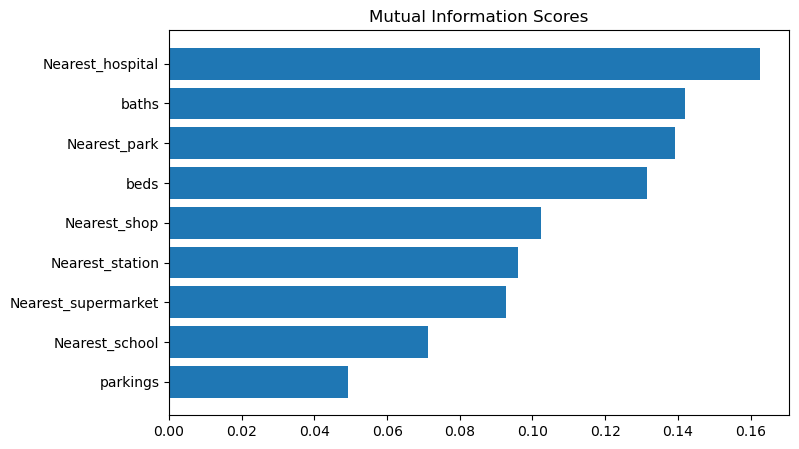

In [15]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# visualize the MI score for each feature
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Based on majority voting, we can conclude that 'Nearest_hospital', 'baths', 'Nearest_park', 'beds' are mainly correlated with the rental price while the 'Nearest_school' and 'parkings' has less significant impact on the rental price.